# Setup

In [1]:
import numpy as np
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations, combinations_with_replacement
from ranker import ScoreRanker

In [2]:
def load_stats_from_directory(base_dir):
    """Loads all run statistics from .pkl files in a given directory."""
    run_files = [os.path.join(base_dir, f"run{i}.pkl") for i in range(1, 11)]
    stats_list = []
    for file_path in run_files:
        if os.path.exists(file_path):
            with open(file_path, "rb") as f:
                eval_summary = pickle.load(f)
                stats_list.append(eval_summary["raw_scores"])
        else:
            print(f"Warning: File not found at {file_path}. Skipping.")
    return stats_list

def get_ranks_from_sorted_indices(sorted_indices):
    """Converts an array of sorted data indices into a rank array."""
    if len(sorted_indices) == 0:
        return np.array([])
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(sorted_indices))
    return ranks

def get_average_final_ranks(list_of_stats, metrics):
    """Calculates the average final-epoch ranks across multiple runs."""
    all_ranks = {metric: [] for metric in metrics}
    for stats in list_of_stats:
        ranker = ScoreRanker(stats)
        ranked_indices = ranker.get_ranked_indices()
        for metric in metrics:
            if metric in ranked_indices and ranked_indices[metric]:
                final_indices = ranked_indices[metric][-1]
                if len(final_indices) > 0:
                    all_ranks[metric].append(get_ranks_from_sorted_indices(final_indices))
    
    avg_ranks = {}
    for metric, ranks_list in all_ranks.items():
        if ranks_list:
            min_len = min(len(r) for r in ranks_list)
            trimmed_ranks = [r[:min_len] for r in ranks_list]
            avg_ranks[metric] = np.mean(np.vstack(trimmed_ranks), axis=0)
    return avg_ranks

def get_cross_seed_correlations(list_of_stats, metrics):
    """Computes pairwise Spearman correlations across seeds for each metric."""
    corrs = {metric: [] for metric in metrics}
    runs_by_metric = {m: [] for m in metrics}

    # Extract final ranks for each run
    for stats in list_of_stats:
        ranker = ScoreRanker(stats)
        ranked_indices = ranker.get_ranked_indices()
        for metric in metrics:
            if metric in ranked_indices and ranked_indices[metric]:
                final_indices = ranked_indices[metric][-1]
                if len(final_indices) > 0:
                    runs_by_metric[metric].append(get_ranks_from_sorted_indices(final_indices))

    # Pairwise correlations
    for metric, ranks in runs_by_metric.items():
        if len(ranks) >= 2:
            min_len = min(len(r) for r in ranks)
            trimmed = [r[:min_len] for r in ranks]
            for i, j in combinations(range(len(trimmed)), 2):
                corr, _ = spearmanr(trimmed[i], trimmed[j])
                if not np.isnan(corr):
                    corrs[metric].append(corr)
    return corrs

In [ ]:
def preprocess_and_save_ranks(base_dir, datasets, model_families, metrics, output_filename):
    """
    Calculates average ranks and cross-seed correlations for all experiments,
    and saves the results to a single file.
    """
    print("--- Starting pre-processing ---")
    results = {"avg_ranks": {}, "cross_seed_corrs": {}}

    for ds in datasets:
        results["avg_ranks"][ds] = {}
        results["cross_seed_corrs"][ds] = {}

        for family in model_families:
            for size in ["base", "large"]:
                model_key = f"{family}_{size}"
                model_path = os.path.join(base_dir, f"{model_key}_{ds.lower()}/")

                print(f"Processing: {model_key} on {ds}...")
                stats_list = load_stats_from_directory(model_path)
                if not stats_list:
                    continue

                # Average ranks
                results["avg_ranks"][ds][model_key] = get_average_final_ranks(stats_list, metrics)

                # Cross-seed correlations
                # Comment this out if the summary isn't needed
                results["cross_seed_corrs"][ds][model_key] = get_cross_seed_correlations(stats_list, metrics)

    # Save everything in one file
    with open(output_filename, "wb") as f:
        pickle.dump(results, f)

    print(f"Pre-processing complete. Data saved to '{output_filename}'")


BASE_ARTIFACT_DIR = "/vol/bitbucket/hrm20/fyp/artifacts/"
DATASETS = ["FEVER", "QQP", "MNLI"]
MODEL_FAMILIES = ["bert", "roberta", "xlnet"]
METRICS = ['aum', 'datamap', 'el2n', 'loss', 'forgetting', 'accuracy', 'grand']
OUTPUT_FILENAME = "training_dynamics_summary.pkl"

if os.path.exists(OUTPUT_FILENAME):
    print(f"'{OUTPUT_FILENAME}' already exists. Skipping pre-processing.")
else:
    print("Pre-processed file not found. Running script.")
    preprocess_and_save_ranks(BASE_ARTIFACT_DIR, DATASETS, MODEL_FAMILIES, METRICS, OUTPUT_FILENAME)

'training_dynamics_summary.pkl' already exists. Skipping pre-processing.


In [5]:
try:
    with open(OUTPUT_FILENAME, "rb") as f:
        preprocessed = pickle.load(f)
        all_ranks = preprocessed["avg_ranks"]
        cross_seed_corrs = preprocessed["cross_seed_corrs"]
except FileNotFoundError:
    print("Error: 'training_dynamics_summary.pkl' not found. Please run the script first.")

In [5]:
def create_plot(df, plot_type, title, filename, **kwargs):
    """Generate plots for RQ1 and RQ2"""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=kwargs.get("figsize", (13, 7)))

    if df.empty:
        ax.text(0.5, 0.5, "No data to plot.", ha='center')
        plt.show()
        return

    if plot_type == 'barplot':
        sns.barplot(data=df, x='Metric', y='Correlation', hue='Group', palette=kwargs.get("palette"), ax=ax)
        ax.set_ylabel(r"Spearman's Correlation ($\rho$)", fontsize=18)
        ax.set_xlabel("Hardness Metric", fontsize=18)
        ax.tick_params(axis='x', rotation=45, labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_ylim(kwargs.get("ylim", (-0.1, 1.05)))
        ax.legend(title=kwargs.get("hue_title"), title_fontsize=16, loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=14)
        plt.subplots_adjust(right=0.80)

    elif plot_type == 'heatmap':
        sns.heatmap(df, annot=True, fmt=".2f", cmap=kwargs.get("palette"), vmin=kwargs.get("vmin"), vmax=kwargs.get("vmax"), ax=ax, annot_kws={"size": 14})
        ax.set_xticklabels(df.columns, rotation=45, ha="right")
        ax.set_yticklabels(df.index, rotation=0)

    ax.set_title(title, fontsize=20, pad=20)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {filename}")

# Research Question 1

In [ ]:
def run_rq1_metric_correlation(model_path, title_name):
    """
    Analyses metric correlations for a single model config across all runs.
    """
    print(f"\n--- Running RQ1: Metric Correlation for {title_name} ---")
    all_stats = load_stats_from_directory(model_path)
    if not all_stats:
        print("No data found, skipping analysis.")
        return

    matrices, method_names = [], None
    for i, stats in enumerate(all_stats):
        ranker = ScoreRanker(stats)
        ranked_indices = ranker.get_ranked_indices()
        methods = list(ranked_indices.keys())
        if method_names is None: method_names = methods
        
        num_epochs = len(next(iter(ranked_indices.values())))
        total_corr = np.zeros((len(methods), len(methods)))
        
        for epoch in range(num_epochs):
            for i, j in combinations_with_replacement(range(len(methods)), 2):
                ranks1 = get_ranks_from_sorted_indices(ranked_indices[methods[i]][epoch])
                ranks2 = get_ranks_from_sorted_indices(ranked_indices[methods[j]][epoch])
                if len(ranks1) > 1 and len(ranks1) == len(ranks2):
                    corr, _ = spearmanr(ranks1, ranks2)
                    total_corr[i, j] += corr if not np.isnan(corr) else 0
                    if i != j: total_corr[j, i] += corr if not np.isnan(corr) else 0
        matrices.append(total_corr / num_epochs)

    if matrices:
        avg_matrix = pd.DataFrame(np.mean(matrices, axis=0), index=method_names, columns=method_names)
        std_matrix = pd.DataFrame(np.std(matrices, axis=0), index=method_names, columns=method_names)
        
        create_plot(avg_matrix, 'heatmap', f"Average Correlation Across Runs\n({title_name})", "rq1_avg_heatmap.png", figsize=(12,10), palette="vlag", vmin=-1, vmax=1)
        create_plot(std_matrix, 'heatmap', f"Std. Dev. of Correlation Across Runs\n({title_name})", "rq1_std_heatmap.png", figsize=(12,10), palette="viridis_r", vmin=0, vmax=0.25)

In [ ]:
run_rq1_metric_correlation(
    model_path=os.path.join(BASE_ARTIFACT_DIR, 'xlnet_base_fever/'),
    title_name="XLNet-Base on FEVER"
)

# Research Question 2

## RQ 2.1

In [ ]:
def run_rq2_cross_scale(datasets, model_family, metrics, preprocessed_ranks):
    """
    Analyses consistency using pre-processed ranks. Runs much faster.
    """
    print(f"\n--- Running RQ2.1: Cross-Scale Consistency for {model_family.upper()} ---")
    plot_data = []
    for ds in datasets:
        ranks_base = preprocessed_ranks.get(ds, {}).get(f"{model_family}_base")
        ranks_large = preprocessed_ranks.get(ds, {}).get(f"{model_family}_large")

        if ranks_base and ranks_large:
            for metric in metrics:
                if metric in ranks_base and metric in ranks_large:
                    corr, _ = spearmanr(ranks_base[metric], ranks_large[metric])
                    plot_data.append({'Group': ds, 'Metric': metric, 'Correlation': corr if not np.isnan(corr) else 0.0})

    df = pd.DataFrame(plot_data)
    create_plot(df, 'barplot', f'{model_family.upper()} Consistency (Base vs. Large)', 'rq2_cross_scale.png', palette='YlGnBu', hue_title='Dataset')

In [ ]:
run_rq2_cross_scale(
    datasets=DATASETS,
    model_family="xlnet",
    metrics=METRICS,
    preprocessed_ranks=all_ranks
)

## RQ 2.2

In [ ]:
def run_rq2_cross_architecture(dataset, model_families, metrics, preprocessed_ranks):
    """
    Analyses consistency between different model architectures using pre-processed ranks.
    """
    print(f"\n--- Running RQ2.2: Cross-Architecture Consistency on {dataset} ---")
    
    avg_ranks = {
        family: preprocessed_ranks.get(dataset, {}).get(f"{family}_base")
        for family in model_families
    }
    
    plot_data = []
    for fam1, fam2 in combinations(model_families, 2):
        # Check if rank data exists for both families
        if avg_ranks.get(fam1) and avg_ranks.get(fam2):
            comparison_key = f"{fam1.upper()} vs {fam2.upper()}"
            for metric in metrics:
                if metric in avg_ranks[fam1] and metric in avg_ranks[fam2]:
                    corr, _ = spearmanr(avg_ranks[fam1][metric], avg_ranks[fam2][metric])
                    plot_data.append({'Group': comparison_key, 'Metric': metric, 'Correlation': corr if not np.isnan(corr) else 0.0})
    
    df = pd.DataFrame(plot_data)
    create_plot(df, 'barplot', f'Cross-Architecture Consistency on {dataset} (Base Models)', f'rq2_cross_arch_{dataset.lower()}.png', palette='Greens', hue_title='Comparison')

In [ ]:
run_rq2_cross_architecture(
    dataset="QQP",
    model_families=MODEL_FAMILIES,
    metrics=METRICS,
    preprocessed_ranks=all_ranks
)

# Research Question 3

In [ ]:
RQ3_MODEL = "bert_large"
RQ3_DATASET = "FEVER"
RQ3_METRICS = ['aum', 'datamap', 'el2n', 'loss', 'forgetting', 'accuracy']

## RQ 3.1

In [ ]:
def run_rq3_seed_stability(model_name, dataset, metrics, base_dir):
    """
    Performs seed stability analysis (RQ 3.1) for a given model and dataset.
    """
    print(f"\n--- Analysing RQ 3.1: Random Seed Stability for {model_name} on {dataset} ---")
    
    # Load the data
    model_path = os.path.join(base_dir, f"{model_name}_{dataset.lower()}/")
    list_of_stats = load_stats_from_directory(model_path)
    if not list_of_stats:
        print("No data found.")
        return

    #Calculate stability scores
    stability_scores = {}
    final_ranks_by_metric = {metric: [] for metric in metrics}
    for stats in list_of_stats:
        ranker = ScoreRanker(stats)
        ranked_indices = ranker.get_ranked_indices()
        for metric in metrics:
            if metric in ranked_indices and ranked_indices[metric]:
                final_ranks = get_ranks_from_sorted_indices(ranked_indices[metric][-1])
                final_ranks_by_metric[metric].append(final_ranks)

    for metric, rank_lists in final_ranks_by_metric.items():
        if len(rank_lists) < 2: continue
        run_pairs = combinations(rank_lists, 2)
        correlations = [spearmanr(r1, r2).correlation for r1, r2 in run_pairs]
        valid_correlations = [c for c in correlations if not np.isnan(c)]
        if valid_correlations:
            stability_scores[metric] = np.mean(valid_correlations)
            
    # Plot the results
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    if stability_scores:
        labels = list(stability_scores.keys())
        values = list(stability_scores.values())
        
        sns.barplot(x=labels, y=values, palette="viridis", width=0.6, ax=ax)
        
        ax.set_title(f'Metric Stability Across Random Seeds\n({model_name.replace("_", "-").title()} on {dataset})', fontsize=16, pad=20)
        ax.set_ylabel(r"Average Pairwise Spearman's Correlation ($\rho$)", fontsize=12)
        ax.set_xlabel("Hardness Metric", fontsize=12)
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='x', rotation=45)
        
        for i, v in enumerate(values):
            ax.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')
            
        plt.tight_layout()
        filename = f"rq3_1_seed_stability_{model_name}_{dataset.lower()}.png"
        plt.savefig(filename, dpi=300)
        plt.show()
        print(f"Plot saved to {filename}")

In [ ]:
run_rq3_seed_stability(
    model_name=RQ3_MODEL,
    dataset=RQ3_DATASET,
    metrics=RQ3_METRICS,
    base_dir=BASE_ARTIFACT_DIR
)

## RQ 3.2

In [ ]:
def run_rq3_epoch_stability(model_name, dataset, metrics, base_dir):
    """
    Performs stability analysis over epochs (RQ 3.2) for a single run.
    """
    print(f"\n--- Analysing RQ 3.2: Epoch Stability for {model_name} on {dataset} (Run 1) ---")
    
    # Load data
    model_path = os.path.join(base_dir, f"{model_name}_{dataset.lower()}/")
    list_of_stats = load_stats_from_directory(model_path)
    if not list_of_stats:
        print("No data found.")
        return
    first_run_stats = list_of_stats[0]
    
    # Calculate scores
    ranker = ScoreRanker(first_run_stats)
    ranked_indices = ranker.get_ranked_indices()
    temporal_scores = {metric: [] for metric in metrics}
    
    for metric in metrics:
        if metric in ranked_indices and ranked_indices[metric]:
            all_epoch_ranks = [get_ranks_from_sorted_indices(e) for e in ranked_indices[metric]]
            if not all_epoch_ranks: continue
            final_ranks = all_epoch_ranks[-1]
            for epoch_ranks in all_epoch_ranks:
                corr, _ = spearmanr(epoch_ranks, final_ranks)
                temporal_scores[metric].append(corr if not np.isnan(corr) else 0.0)

    # Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if any(temporal_scores.values()):
        for metric, scores in temporal_scores.items():
            if scores:
                epochs = np.arange(1, len(scores) + 1)
                sns.lineplot(x=epochs, y=scores, label=metric.capitalize(), marker='o', markersize=7, lw=2.5, ax=ax)
        
        ax.set_title(f'Metric Stability Across Epochs\n({model_name.replace("_", "-").title()} on {dataset})', fontsize=16, pad=20)
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel(r"Spearman's Correlation ($\rho$) vs. Final Epoch Rank", fontsize=12)
        ax.legend(title="Metric")
        ax.grid(True, which='both', linestyle='--')
        ax.set_xticks(epochs)
        fig.tight_layout()
        filename = f"rq3_2_temporal_stability_{model_name}_{dataset.lower()}.png"
        plt.savefig(filename, dpi=300)
        plt.show()
        print(f"Plot saved to {filename}")

In [ ]:
run_rq3_epoch_stability(
    model_name=RQ3_MODEL,
    dataset=RQ3_DATASET,
    metrics=RQ3_METRICS,
    base_dir=BASE_ARTIFACT_DIR
)

# Summary

In [10]:
# --- Cross-Seed: compares different runs of the same experiments ---
for ds in DATASETS:
    for model_key, metrics_dict in cross_seed_corrs.get(ds, {}).items():
        for metric, corrs in metrics_dict.items():
            summary_scores['Cross-Seed'][metric].extend(corrs)

# --- Cross-Scale: base vs large for each family ---
for ds in DATASETS:
    for family in MODEL_FAMILIES:
        base = all_ranks.get(ds, {}).get(f"{family}_base", {})
        large = all_ranks.get(ds, {}).get(f"{family}_large", {})
        for metric in METRICS:
            if metric in base and metric in large:
                n = min(len(base[metric]), len(large[metric]))
                if n > 0:
                    corr, _ = spearmanr(base[metric][:n], large[metric][:n])
                    if not np.isnan(corr):
                        summary_scores['Cross-Scale'][metric].append(corr)

# --- Cross-Architecture: compare different families (base models only) ---
for ds in DATASETS:
    metric_ranks = {f: all_ranks.get(ds, {}).get(f"{f}_base", {}) for f in MODEL_FAMILIES}
    for metric in METRICS:
        ranks = [metric_ranks[f][metric] for f in MODEL_FAMILIES if metric in metric_ranks[f]]
        if len(ranks) >= 2:
            n = min(len(r) for r in ranks)
            trimmed = [r[:n] for r in ranks]
            for i, j in combinations(range(len(trimmed)), 2):
                corr, _ = spearmanr(trimmed[i], trimmed[j])
                if not np.isnan(corr):
                    summary_scores['Cross-Architecture'][metric].append(corr)

# --- Remove 'grand' if missing data ---
filtered_summary_scores = {
    abl: {m: s for m, s in metric_dict.items() if m != 'grand'}
    for abl, metric_dict in summary_scores.items()
}

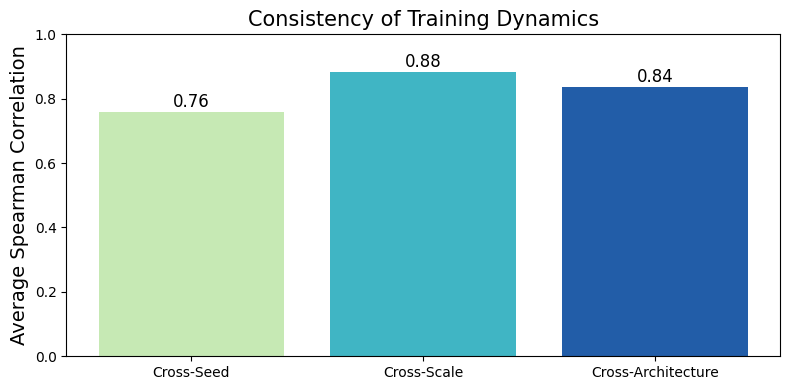

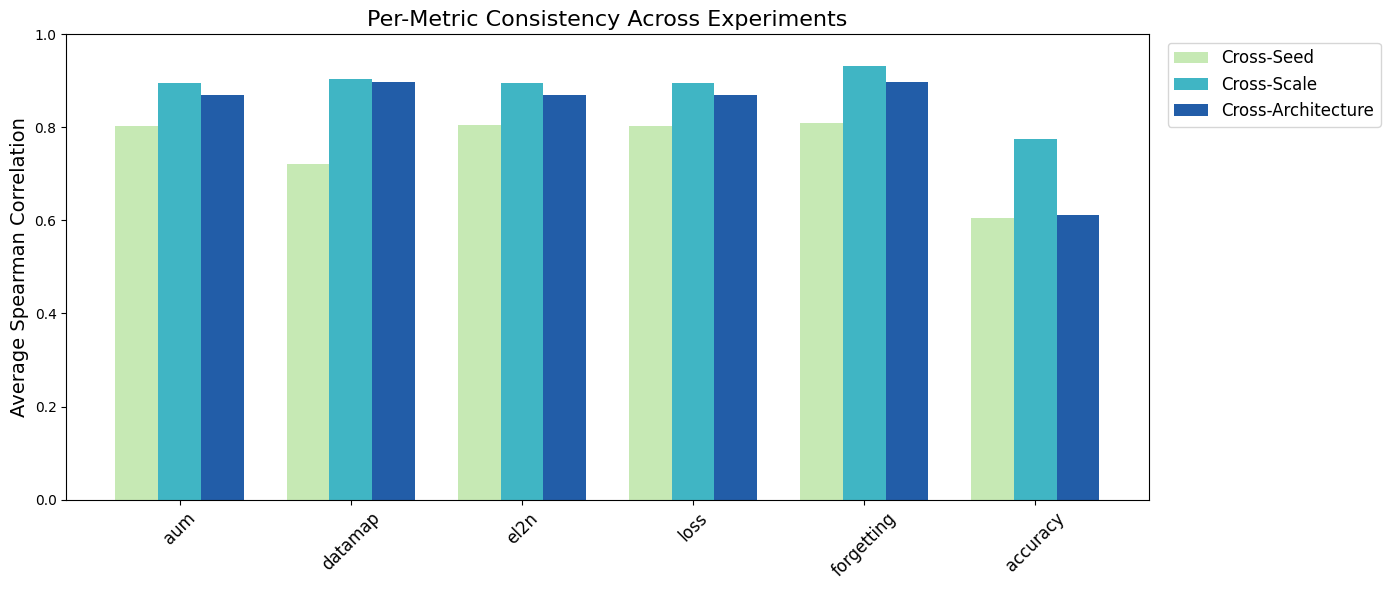

In [11]:
# --- Plot 1: Overall summary ---
labels = list(filtered_summary_scores.keys())
palette = sns.color_palette("YlGnBu", n_colors=len(labels))

mean_scores = [
    np.mean([s for scores in filtered_summary_scores[abl].values() for s in scores])
    for abl in labels
]

plt.figure(figsize=(8,4))
bars = plt.bar(labels, mean_scores, color=palette)
plt.ylabel("Average Spearman Correlation", fontsize=14)
plt.title("Consistency of Training Dynamics", fontsize=15)
plt.ylim(0,1)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h+0.015, f"{h:.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("summary_bar_chart.png", dpi=300)
plt.show()

# --- Plot 2: Per-metric grouped ---
metrics = list(filtered_summary_scores['Cross-Seed'].keys())
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(14,6))
for i,(abl,color) in enumerate(zip(labels, palette)):
    means = [np.mean(filtered_summary_scores[abl][m]) for m in metrics]
    plt.bar(x+i*width, means, width=width, label=abl, color=color)

plt.xticks(x+width*(len(labels)-1)/2, metrics, rotation=45, fontsize=12)
plt.ylim(0,1)
plt.ylabel("Average Spearman Correlation", fontsize=14)
plt.title("Per-Metric Consistency Across Experiments", fontsize=16)
plt.legend(loc="upper left", bbox_to_anchor=(1.01,1), fontsize=12)
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.savefig("per_metric_chart.png", dpi=300)
plt.show()